In [1]:
!pip install pandas numpy scikit-learn imbalanced-learn matplotlib seaborn


Defaulting to user installation because normal site-packages is not writeable

   ---------------------------------------- 0/2 [sklearn-compat]
   ---------------------------------------- 0/2 [sklearn-compat]
   ---------------------------------------- 0/2 [sklearn-compat]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalan


[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    auc
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import NearMiss

# Create outputs folder
os.makedirs("outputs", exist_ok=True)


In [14]:
data = pd.read_csv("data/Creditcard_data.csv")
data.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,1
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Class Distribution:

Class
0    763
1      9
Name: count, dtype: int64


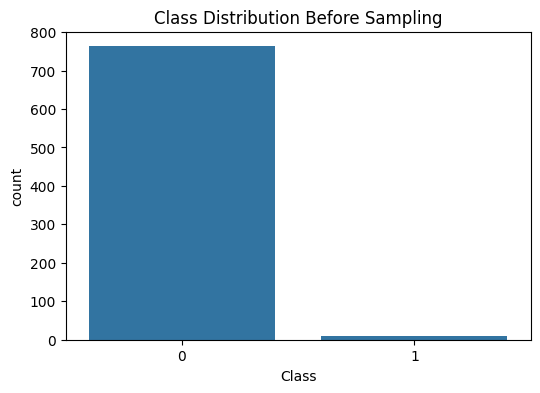

In [15]:
print("Class Distribution:\n")
print(data['Class'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=data)
plt.title("Class Distribution Before Sampling")
plt.savefig("outputs/class_distribution.png", dpi=300, bbox_inches='tight')
plt.show()


In [16]:
X = data.drop("Class", axis=1)
y = data["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [17]:
sampling_methods = {
    "SMOTETomek": SMOTETomek(random_state=42),
    "SMOTEENN": SMOTEENN(random_state=42),
    "BorderlineSMOTE": BorderlineSMOTE(random_state=42),
    "NearMissV2": NearMiss(version=2),
    "CostSensitive": None
}


In [18]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "DecisionTree": DecisionTreeClassifier(class_weight="balanced"),
    "RandomForest": RandomForestClassifier(class_weight="balanced"),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(class_weight="balanced", probability=True)
}


In [19]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1_Score": f1_score(y_test, y_pred),
        "ROC_AUC": roc_auc_score(y_test, y_prob) if y_prob is not None else None
    }


In [20]:
results = []

for s_name, sampler in sampling_methods.items():

    if sampler is not None:
        X_res, y_res = sampler.fit_resample(X_train, y_train)
    else:
        X_res, y_res = X_train, y_train

    for m_name, model in models.items():
        model.fit(X_res, y_res)
        metrics = evaluate_model(model, X_test, y_test)

        metrics["Model"] = m_name
        metrics["Sampling"] = s_name
        results.append(metrics)

results_df = pd.DataFrame(results)
results_df


C:\Users\beere\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\beere\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\beere\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\User

,Accuracy,Precision,Recall,F1_Score,ROC_AUC,Model,Sampling
0,0.939655,0.076923,0.333333,0.125000,0.694323,LogisticRegression,SMOTETomek
1,0.978448,0.333333,0.666667,0.444444,0.824600,DecisionTree,SMOTETomek
2,0.991379,1.000000,0.333333,0.500000,0.709607,RandomForest,SMOTETomek
3,0.948276,0.000000,0.000000,0.000000,0.620087,KNN,SMOTETomek
4,0.965517,0.000000,0.000000,0.000000,0.670306,SVM,SMOTETomek
5,0.948276,0.090909,0.333333,0.142857,0.708879,LogisticRegression,SMOTEENN
6,0.974138,0.285714,0.666667,0.400000,0.822416,DecisionTree,SMOTEENN
7,0.991379,1.000000,0.333333,0.500000,0.776565,RandomForest,SMOTEENN
8,0.935345,0.000000,0.000000,0.000000,0.614993,KNN,SMOTEENN
9,0.956897,0.000000,0.000000,0.000000,0.650655,SVM,SMOTEENN


In [21]:
results_df.to_csv("outputs/results_table.csv", index=False)


In [22]:
accuracy_table = results_df.pivot(
    index="Model",
    columns="Sampling",
    values="Accuracy"
)

accuracy_table.to_csv("outputs/accuracy_table.csv")
accuracy_table


Sampling,BorderlineSMOTE,CostSensitive,NearMissV2,SMOTEENN,SMOTETomek
Model,,,,,
DecisionTree,0.991379,0.987069,0.370690,0.974138,0.978448
KNN,0.987069,0.987069,0.956897,0.935345,0.948276
LogisticRegression,0.918103,0.918103,0.452586,0.948276,0.939655
RandomForest,0.987069,0.987069,0.340517,0.991379,0.991379
SVM,0.961207,0.961207,0.323276,0.956897,0.965517


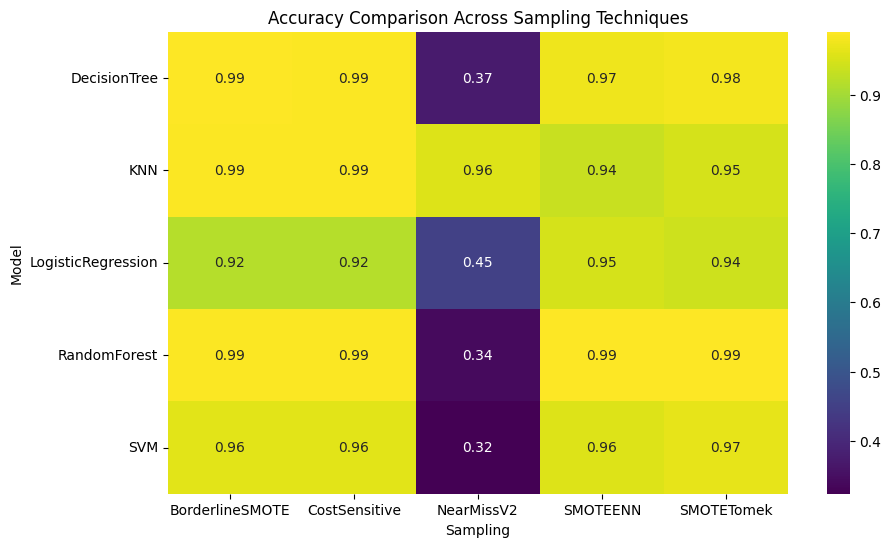

In [23]:
plt.figure(figsize=(10,6))
sns.heatmap(accuracy_table, annot=True, cmap="viridis")
plt.title("Accuracy Comparison Across Sampling Techniques")
plt.savefig("outputs/accuracy_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()


In [24]:
best_row = results_df.loc[results_df['F1_Score'].idxmax()]
best_row


Accuracy            0.991379
Precision           0.666667
Recall              0.666667
F1_Score            0.666667
ROC_AUC              0.83115
Model           DecisionTree
Sampling     BorderlineSMOTE
Name: 11, dtype: object

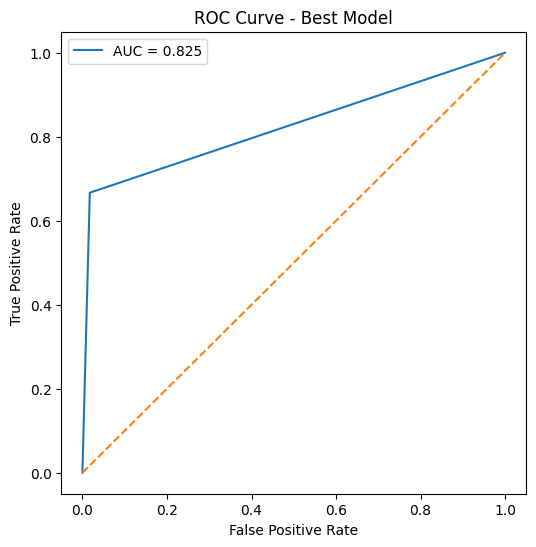

In [25]:
best_model_name = best_row["Model"]
best_sampling_name = best_row["Sampling"]

model = models[best_model_name]
sampler = sampling_methods[best_sampling_name]

if sampler is not None:
    X_res, y_res = sampler.fit_resample(X_train, y_train)
else:
    X_res, y_res = X_train, y_train

model.fit(X_res, y_res)
y_prob = model.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Best Model")
plt.legend()
plt.savefig("outputs/roc_curve.png", dpi=300, bbox_inches='tight')
plt.show()


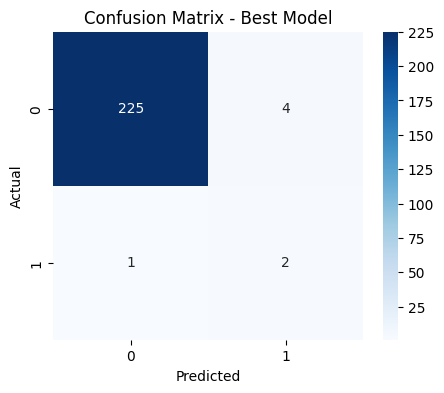

In [26]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Best Model")
plt.savefig("outputs/confusion_matrix_best_model.png", dpi=300, bbox_inches='tight')
plt.show()
